# Omvandla en metadatafil från Qiime2 till nåt läsbart

In [1]:
# Importera pandas och filen med metadata
import pandas as pd

metadata_reads = pd.read_csv('metadata.tsv', sep='\t', index_col='Feature ID', skiprows = [1])

In [2]:
# Gör en kopia för att inte sabba orginaldatan
dataset = metadata_reads.copy(deep=True)

# Dela upp kolumnen "Taxon i de olika taxonomiska nivåerna som använts
# Radera den ursprungliga kolumnen
taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
dataset[taxonomic_levels] = metadata_reads['Taxon'].str.split(';', expand=True)
dataset.drop('Taxon', axis=1, inplace=True)

In [3]:
# Ta bort de taxonomiska nivåerna i namnen, ex k__Bacteria --> Bacteria
# Använd reguljäruttryck

import regex as re
def rename(name):
    if name:
        return re.sub('.{1}__', '', name)

for row in range(len(dataset)):
    for column in range(len(taxonomic_levels)):
        name = dataset.iloc[row, 1+column]
        dataset.iloc[row, 1+column] = rename(name)
    dataset.iloc[row, :].str.strip()

## Testa så att det funkar med plotkoden

In [4]:
def find_nulls(dataframe):
    '''Tar en dataframe och beräknar antalet sekvenser (rader, S) som klassifierats på olika nivåer (kolumner, L),
    Input: En dataframe (S*L) med sekvenser som rader, och taxonomisk tillhörighet på olika nivåer som kolumner,
    Output: Två nya dataframes som innehåller:,
    - Antalet sekvenser som klassifierats på respektive taxonomisk nivå (L*1),
    - Antalet sekvenser som har respektive taxonomisk nivå som sin högsta (ex bara klassifierats till family level) (1*L)'''

    class_all_levels = dataframe.notnull().sum()
    class_highest_level = class_all_levels.copy(deep=True)
    for level in range(len(class_all_levels)-1):
        class_highest_level[level] -= class_all_levels[level+1]
    class_all_levels = class_all_levels.to_frame()
    class_highest_level = class_highest_level.to_frame().transpose()
    
    return class_all_levels, class_highest_level

In [5]:
class_all_levels, class_highest_level = find_nulls(dataset.iloc[:, 1:])

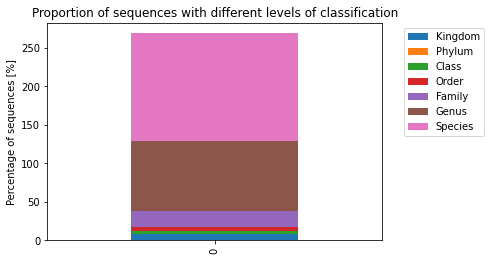

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
class_highest_level.plot(kind='bar', stacked=True, title='Proportion of sequences with different levels of classification', 
                        ylabel='Percentage of sequences [%]', ax=ax)
# ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()